In [1]:
import tensorflow as tf
import models.official.resnet.resnet_model as resnet_model
import models.official.resnet.resnet_run_loop as resnet_run_loop
from models.official.utils.export import export
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Input,Activation,Dense,Flatten,Concatenate,Lambda,TimeDistributed,Reshape
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import six
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv3D,Conv2D,MaxPooling2D,AveragePooling2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import skimage.io
import matplotlib.pyplot as plt
import os
import sys

Using TensorFlow backend.


In [2]:
#%run -i ./models/official/resnet/cifar10_main.py
_HEIGHT = 32
_WIDTH = 32
_NUM_CHANNELS = 3
_DEFAULT_IMAGE_BYTES = _HEIGHT * _WIDTH * _NUM_CHANNELS
# The record is the image plus a one-byte label
_RECORD_BYTES = _DEFAULT_IMAGE_BYTES + 1
_NUM_CLASSES = 10
_NUM_DATA_FILES = 5

_NUM_IMAGES = {
    'train': 50000,
    'validation': 10000,
}

###############################################################################
# Data processing
###############################################################################
import os
import pickle

def get_filenames(is_training, data_dir):
  """Returns a list of filenames."""
  data_dir = os.path.join(data_dir, 'cifar-10-batches-bin')

  assert os.path.exists(data_dir), (
      'Run cifar10_download_and_extract.py first to download and extract the '
      'CIFAR-10 data.')

  if is_training:
    return [
        os.path.join(data_dir, 'data_batch_%d.bin' % i)
        for i in range(1, _NUM_DATA_FILES + 1)
    ]
  else:
    return [os.path.join(data_dir, 'test_batch.bin')]


def parse_record(raw_record, is_training):
  """Parse CIFAR-10 image and label from a raw record."""
  # Convert bytes to a vector of uint8 that is record_bytes long.
  record_vector = tf.decode_raw(raw_record, tf.uint8)

  # The first byte represents the label, which we convert from uint8 to int32
  # and then to one-hot.
  label = tf.cast(record_vector[0], tf.int32)
  label = tf.one_hot(label, _NUM_CLASSES)

  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
  depth_major = tf.reshape(record_vector[1:_RECORD_BYTES],
                           [_NUM_CHANNELS, _HEIGHT, _WIDTH])

  # Convert from [depth, height, width] to [height, width, depth], and cast as
  # float32.
  image = tf.cast(tf.transpose(depth_major, [1, 2, 0]), tf.float32)

  image = preprocess_image(image, is_training)

  return image, label


def preprocess_image(image, is_training):
  """Preprocess a single image of layout [height, width, depth]."""
  if is_training:
    # Resize the image to add four extra pixels on each side.
    image = tf.image.resize_image_with_crop_or_pad(
        image, _HEIGHT + 8, _WIDTH + 8)

    # Randomly crop a [_HEIGHT, _WIDTH] section of the image.
    image = tf.random_crop(image, [_HEIGHT, _WIDTH, _NUM_CHANNELS])

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)

  # Subtract off the mean and divide by the variance of the pixels.
  image = tf.image.per_image_standardization(image)
  return image

def input_fn(is_training, data_dir, batch_size, num_epochs=1,
             num_parallel_calls=1, multi_gpu=False):
  """Input_fn using the tf.data input pipeline for CIFAR-10 dataset.

  Args:
    is_training: A boolean denoting whether the input is for training.
    data_dir: The directory containing the input data.
    batch_size: The number of samples per batch.
    num_epochs: The number of epochs to repeat the dataset.
    num_parallel_calls: The number of records that are processed in parallel.
      This can be optimized per data set but for generally homogeneous data
      sets, should be approximately the number of available CPU cores.
    multi_gpu: Whether this is run multi-GPU. Note that this is only required
      currently to handle the batch leftovers, and can be removed
      when that is handled directly by Estimator.

  Returns:
    A dataset that can be used for iteration.
  """
  filenames = get_filenames(is_training, data_dir)
  dataset = tf.data.FixedLengthRecordDataset(filenames, _RECORD_BYTES)

  num_images = is_training and _NUM_IMAGES['train'] or _NUM_IMAGES['validation']

  return resnet_run_loop.process_record_dataset(
      dataset, is_training, batch_size, _NUM_IMAGES['train'],
      parse_record, num_epochs, num_parallel_calls,
      examples_per_epoch=num_images, multi_gpu=multi_gpu)


def get_synth_input_fn():
  return resnet_run_loop.get_synth_input_fn(
      _HEIGHT, _WIDTH, _NUM_CHANNELS, _NUM_CLASSES)

In [3]:
class Cifar10Model(resnet_model.Model):
  """Model class with appropriate defaults for CIFAR-10 data."""

  def __init__(self, resnet_size, data_format=None, num_classes=_NUM_CLASSES,
               version=resnet_model.DEFAULT_VERSION,
               dtype=resnet_model.DEFAULT_DTYPE):
    """These are the parameters that work for CIFAR-10 data.

    Args:
      resnet_size: The number of convolutional layers needed in the model.
      data_format: Either 'channels_first' or 'channels_last', specifying which
        data format to use when setting up the model.
      num_classes: The number of output classes needed from the model. This
        enables users to extend the same model to their own datasets.
      version: Integer representing which version of the ResNet network to use.
        See README for details. Valid values: [1, 2]
      dtype: The TensorFlow dtype to use for calculations.

    Raises:
      ValueError: if invalid resnet_size is chosen
    """
    if resnet_size % 6 != 2:
      raise ValueError('resnet_size must be 6n + 2:', resnet_size)

    num_blocks = (resnet_size - 2) // 6

    super(Cifar10Model, self).__init__(
        resnet_size=resnet_size,
        bottleneck=False,
        num_classes=num_classes,
        num_filters=16,
        kernel_size=3,
        conv_stride=1,
        first_pool_size=None,
        first_pool_stride=None,
        second_pool_size=8,
        second_pool_stride=1,
        block_sizes=[num_blocks] * 3,
        block_strides=[1, 2, 2],
        final_size=64,
        version=version,
        data_format=data_format,
        dtype=dtype
    )


In [4]:
def cifar10_model_fn(features, labels, mode, params):
  """Model function for CIFAR-10."""
  features = tf.reshape(features, [-1, _HEIGHT, _WIDTH, _NUM_CHANNELS])
  print(features.shape)
  learning_rate_fn = resnet_run_loop.learning_rate_with_decay(
      batch_size=params['batch_size'], batch_denom=128,
      num_images=_NUM_IMAGES['train'], boundary_epochs=[100, 150, 200],
      decay_rates=[1, 0.1, 0.01, 0.001])

  # We use a weight decay of 0.0002, which performs better
  # than the 0.0001 that was originally suggested.
  weight_decay = 2e-4

  # Empirical testing showed that including batch_normalization variables
  # in the calculation of regularized loss helped validation accuracy
  # for the CIFAR-10 dataset, perhaps because the regularization prevents
  # overfitting on the small data set. We therefore include all vars when
  # regularizing and computing loss during training.
  def loss_filter_fn(_):
    return True

  return resnet_run_loop.resnet_model_fn(
      features=features,
      labels=labels,
      mode=mode,
      model_class=Cifar10Model,
      resnet_size=params['resnet_size'],
      weight_decay=weight_decay,
      learning_rate_fn=learning_rate_fn,
      momentum=0.9,
      data_format=params['data_format'],
      version=params['version'],
      loss_scale=params['loss_scale'],
      loss_filter_fn=loss_filter_fn,
      dtype=params['dtype']
  )

In [5]:
def main(argv):
    #args = parser.parse_args(argv[1:])
    
    flags={
      'train_epochs': 250,
      'max_train_steps': 30000,
      'epochs_between_evals': 10,
      'batch_size': 128,
      'train_steps':1000,
      'model_dir':'model_dir',
      'data_dir':'cifar10_data',
      'test_dir':'cifar10_data',
      'export_dir':'export_dir',
      'resnet_size':50,
      'data_format':None,
      'multi_gpu':False,
      'version':2,
      'loss_scale':1,
      'use_synthetic_data':False,
      'num_parallel_calls':1, # might provide speed boost in the future
      'dtype':'float32',
      'hooks': None,
      'stop_threshold': 0.90,
      'benchmark_log_dir': 'benchmark_log_dir',
    }
    #'hooks': ['LoggingTensorHook', 'ProfilerHook', 'ExamplesPerSecondHook'],
    
    # Extract the training data here
    
    
    # Build 2 hidden layer DNN with 10, 10 units respectively.
    classifier = tf.estimator.Estimator(
        model_fn=cifar10_model_fn,
        model_dir=flags['model_dir'],
        params={
          'resnet_size': flags['resnet_size'],
          'data_format': flags['data_format'],
          'batch_size': flags['batch_size'],
          'multi_gpu': flags['multi_gpu'],
          'version': flags['version'],
          'loss_scale': flags['loss_scale'],
          'dtype': flags['dtype'],
      })

    return classifier,flags

def train(classifier,flags):
  input_function = flags['use_synthetic_data'] and get_synth_input_fn() or input_fn

  for _ in range(flags['train_epochs'] // flags['epochs_between_evals']):

    print('Starting a training cycle.')

    def input_fn_train():
      return input_function(True, flags['data_dir'], flags['batch_size'],
                            flags['epochs_between_evals'],
                            flags['num_parallel_calls'], flags['multi_gpu'])

    classifier.train(input_fn=input_fn_train,
                     max_steps=flags['max_train_steps'])

    print('Starting to evaluate.')
    # Evaluate the model and print results
    def input_fn_eval():
      return input_function(False, flags['data_dir'], flags['batch_size'],
                            1, flags['num_parallel_calls'], flags['multi_gpu'])

    # flags.max_train_steps is generally associated with testing and profiling.
    # As a result it is frequently called with synthetic data, which will
    # iterate forever. Passing steps=flags.max_train_steps allows the eval
    # (which is generally unimportant in those circumstances) to terminate.
    # Note that eval will run for max_train_steps each loop, regardless of the
    # global_step count.
    eval_results = classifier.evaluate(input_fn=input_fn_eval,
                                       steps=flags['max_train_steps'])

def input_fn(is_training, data_dir, batch_size, num_epochs=1,
             num_parallel_calls=1, multi_gpu=False):
  """Input_fn using the tf.data input pipeline for CIFAR-10 dataset.

  Args:
    is_training: A boolean denoting whether the input is for training.
    data_dir: The directory containing the input data.
    batch_size: The number of samples per batch.
    num_epochs: The number of epochs to repeat the dataset.
    num_parallel_calls: The number of records that are processed in parallel.
      This can be optimized per data set but for generally homogeneous data
      sets, should be approximately the number of available CPU cores.
    multi_gpu: Whether this is run multi-GPU. Note that this is only required
      currently to handle the batch leftovers, and can be removed
      when that is handled directly by Estimator.

  Returns:
    A dataset that can be used for iteration.
  """
  filenames = get_filenames(is_training, data_dir)
  dataset = tf.data.FixedLengthRecordDataset(filenames, _RECORD_BYTES)

  num_images = is_training and _NUM_IMAGES['train'] or _NUM_IMAGES['validation']

  return resnet_run_loop.process_record_dataset(
      dataset, is_training, batch_size, _NUM_IMAGES['train'],
      parse_record, num_epochs, num_parallel_calls,
      examples_per_epoch=num_images, multi_gpu=multi_gpu)
        
if __name__ == "__main__":
    tf.logging.set_verbosity(tf.logging.INFO)
    classifier, flags = main(None)
    
    input_function = flags['use_synthetic_data'] and get_synth_input_fn() or input_fn

    resnet_run_loop.resnet_main(
        flags, cifar10_model_fn, input_function,
        shape=[_HEIGHT, _WIDTH, _NUM_CHANNELS])


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026CA43EA860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using config: {'_model_dir': 'model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 1000000000.0, '_session_config': allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distr

In [6]:
import numpy as np

def predict(classifier,batch_size):
    # Generate predictions from the model
    predictions = classifier.predict(
        input_fn=lambda:input_fn(False, flags['test_dir'], flags['batch_size'],
                            1, flags['num_parallel_calls'], flags['multi_gpu'])
        )
    
    layer1 = []
    layer2 = []
    layer3 = []
    layer4 = []
    for pred_dict in zip(predictions):
        layer1.append(pred_dict[0]['layer1'])
        layer2.append(pred_dict[0]['layer2'])
        layer3.append(pred_dict[0]['layer3'])
        layer4.append(pred_dict[0]['layer4'])
    print(np.array(layer1).shape)
    print(np.array(layer2).shape)
    print(np.array(layer3).shape)
    print(np.array(layer4).shape)
    
    # Create skip_features tensor here
    skip_features = np.zeros((1,224,224,128))
    
    return skip_features
    
# Predict the results
skip_features = predict(classifier,batch_size=128)

INFO:tensorflow:Calling model_fn.
(?, 32, 32, 3)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_dir\model.ckpt-42977
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(10000, 16, 32, 32)
(10000, 16, 32, 32)
(10000, 32, 16, 16)
(10000, 64, 8, 8)


In [38]:
conv2dlstm = Sequential()
# Add the 2D convolutional LSTM layers here
conv2dlstm.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   input_shape=(None, 28, 28, 1),
                   padding='same', return_sequences=True))
conv2dlstm.add(BatchNormalization())

conv2dlstm.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
conv2dlstm.add(BatchNormalization())

conv2dlstm.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

In [39]:
conv2dlstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 28, 28, 64)  150016    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 28, 28, 64)  256       
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, None, 28, 28, 16)  46144     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 28, 28, 16)  64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, None, 28, 28, 1)   433       
Total params: 196,913
Trainable params: 196,753
Non-trainable params: 160
_________________________________________________________________


(1, 4, 224, 224, 3)
(224, 224, 3)


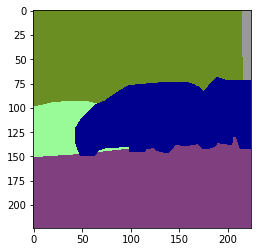

In [9]:
# Get input image for testing purposes
img = []
img.append(skimage.io.imread('./gtFine_trainvaltest/gtFine/train/erfurt/erfurt_000000_000019_gtFine_color.png'))

# Crop the section of the image that will be run through the network (224x224x3)
img_crop = np.array(img[0][350:574,500:724,:3])
img_feed = np.reshape(img_crop, [-1,1,224,224,3])
img_feed = np.concatenate([img_feed,img_feed,img_feed,img_feed], axis=1)
plt.figure()
plt.imshow(img_crop)
print(img_feed.shape)
print(img_crop.shape)

In [10]:
pred = resnet50.predict(img_feed)

In [11]:
print(pred.shape)

(1, 4, 224, 224, 1)


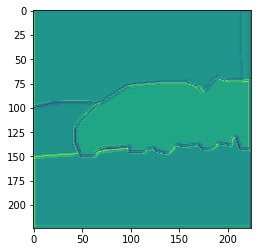

In [12]:
plt.imshow(np.squeeze(pred[0,3,:,:,:]))

In [13]:
from keras import backend as K
input_shape = [1,224,224,3]
inp = resnet50.input                                           # input placeholder
outputs = [layer.output for layer in resnet50.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
#test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = functor([img_feed, 1.])
hidden1 = layer_outs[1]
hidden2 = layer_outs[3]

def f_1(hidden1):
    model = Sequential()
    x = Input(shape=(4,224,224,64))
    y = Dense(128)(x)
    model = Model(x, y)
    pred = model.predict(hidden1)
    return pred

def f_2(hidden2):
    model = Sequential()
    x = Input(shape=(4,224,224,16))
    y = Dense(128)(x)
    model = Model(x, y)
    pred = model.predict(hidden2)
    return pred

def f_att(skip_features, f1, f2):
    inp = skip_features + f1 + f2
    model = Sequential()
    x = Input(shape=(4,224,224,128))
    y = Dense(1, activation='softmax')(x) # softmax here is required
    model = Model(x, y)
    pred = model.predict(inp)
    return pred


In [14]:
f1 = f_1(hidden1)
f2 = f_2(hidden2)
fatt = f_att(skip_features, f1, f2)
print(f1.shape)
print(f2.shape)
print(fatt.shape)

(1, 4, 224, 224, 128)
(1, 4, 224, 224, 128)
(1, 4, 224, 224, 1)


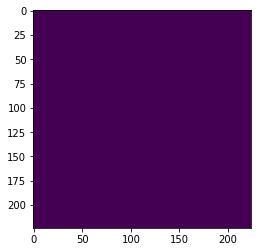

In [15]:
plt.figure()
plt.imshow(np.squeeze(fatt[0,0,:,:,:]))
# plt.figure()
# plt.imshow(np.squeeze(img_feed[0,0,:,:,:]))
# plt.figure()
# plt.imshow(np.squeeze(f1[0,0,:,:,1]))


In [16]:
import json
import numpy as np
import cv2 as cv
import glob

def extract_data(img,mode,wdt_orig,hgt_orig,wdt_new,hgt_new):
    path_to_data = './gtFine_trainvaltest/'

    if (mode=='train'):
        spec_path = path_to_data+'gtFine/train/*'
    elif (mode=='valid'):
        spec_path = path_to_data+'gtFine/val/*'
    elif (mode=='test'):
        spec_path = path_to_data+'gtFine/test/*'
        
    all_folders = glob.glob(spec_path)
    filenames = []
    out = []
    data = []

    # Extract the filepaths into one ginormous array
    for i in range(len(all_folders)):
        temp = glob.glob(all_folders[i]+'/*_color*.png') # ignore the masks
        for j in temp:
            filenames.append(j) 
    
    for inst in filenames:
        print('Extracting image data from file: {}'.format(inst))
        filename_crop = inst[:-10]
        filename_poly = filename_crop + '_polygons.json'

        # Extract polygon information here
        with open(filename_poly) as json_file:
            data.append(json.load(json_file))

        # Convert the image into a numpy array for training purposes
        #img = skimage.io.imread(filename) # For testing
        img = cv.imread(inst) # For testing
        height, width = img.shape[:2]

        # Reshape the file here
        res = cv.resize(img,(int(width/(wdt_orig/wdt_new)), int(height/(hgt_orig/hgt_new))), interpolation = cv.INTER_CUBIC)
        out.append(np.reshape(res, [1,hgt_new,wdt_new,3]))
        
    return np.array(out), np.array(data)

def ptsToMask(img,pts,output,wdt_orig,hgt_orig,wdt_new,hgt_new):
    entry_set = img
    
    # Determine max no. of consecutive points
    pts_qty = len(pts)
    max_val = int(pts_qty/3)*3
    
    for i,coords in enumerate(pts):
        # Create the mask here
        mask = np.zeros((1,1,hgt_new,wdt_new,3))

        # Scale the coordinate values here
        coords[0] = int(coords[0]*(wdt_new/wdt_orig))-1
        coords[1] = int(coords[1]*(hgt_new/hgt_orig))-1

        # Create the mask here
        mask[0, 0, coords[1], coords[0]] = 1

        # Concatenate the mask here to the object
        entry_set = np.concatenate([entry_set,mask], axis=1)

        # reset arrays here
        if (entry_set.shape[1]==4):
            output = np.concatenate([output,entry_set], axis=0)
            entry_set = img
            
        # Break the loop if there are no more sets of 3 left
        if (i+1==max_val):
            break;
    
    return output
    

In [17]:
# # Original
# wdt_orig = 2048
# hgt_orig = 1024
# wdt_new = 2048
# hgt_new = 1024
# img_orig, data = extract_data(None,wdt_orig,hgt_orig,wdt_new,hgt_new)
# plt.figure()
# plt.imshow(img_orig)
# mask_orig = ptsToMask(img_orig,data,wdt_orig,hgt_orig,wdt_new,hgt_new)
# plt.figure()
# plt.imshow(mask_orig)

# # Get the keys
# print(data.keys())

# New
wdt_orig = 2048
hgt_orig = 1024
wdt_new = 28
hgt_new = 28
mode = 'train'
path = './imgData.pkl'

if (os.path.isfile(path)):
    with open(path, "rb") as f:
        try:
            img_train, data_train = pickle.load(f)
        except: 
            print('Error Encountered!')
else:
    img_train, data_train = extract_data(None,mode,wdt_orig,hgt_orig,wdt_new,hgt_new)
    with open(path, "wb") as f:
        pickle.dump([img_train, data_train], f)


Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000000_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000001_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000002_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000003_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000004_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000005_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000006_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000007_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000008_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000073_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000074_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000075_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000076_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000077_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000078_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000079_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000080_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000081_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000146_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000147_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000148_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000149_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000150_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000151_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000152_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000153_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\aachen\aachen_000154_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_020899_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_021070_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_021325_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_021393_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_021479_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_021606_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_022210_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_022414_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bochum\bochum_000000_023040_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000028_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000029_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000030_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000031_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000032_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000033_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000034_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000035_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000036_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000105_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000106_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000107_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000108_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000109_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000110_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000111_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000112_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000113_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000183_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000184_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000185_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000186_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000187_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000188_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000189_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000190_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000191_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000260_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000261_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000262_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000263_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000264_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000265_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000266_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000267_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\bremen\bremen_000268_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000021_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000022_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000023_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000024_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000025_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000026_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000027_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000028_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\colo

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000095_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000096_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000097_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000098_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000099_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000100_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000101_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\cologne_000102_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\cologne\colo

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000014_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000015_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000016_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000017_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000018_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000019_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000020_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\darmstadt\darmstadt_000021_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainv

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000002_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000003_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000004_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000005_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000006_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000007_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000008_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000009_000019_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000074_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000075_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000076_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000077_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000078_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000079_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000080_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000081_000019_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000147_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000148_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000149_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000150_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000151_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000152_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000153_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000154_000019_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000216_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000217_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000218_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000219_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000220_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000000_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000001_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000002_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/g

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000069_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000070_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000071_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000072_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000073_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000074_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000075_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000076_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\erfurt\erfurt_000077_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_025802_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_025986_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_026675_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_027304_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_027857_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_028056_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_028439_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_028608_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamb

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_054220_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_054555_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_054850_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_055039_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_055414_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_055894_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_056229_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_056508_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamb

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_079657_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_080169_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_080438_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_080674_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_080878_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_081299_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_082187_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamburg_000000_082301_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hamburg\hamb

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_002458_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_003224_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_003411_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_003853_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_004230_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_004646_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_004752_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_005175_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hano

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027390_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027481_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027561_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027650_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027766_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_027998_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_028202_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_028460_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hano

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_046954_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_047499_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_047629_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_047870_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_048274_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_048379_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_048508_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hanover_000000_048765_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\hanover\hano

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000034_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000035_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000036_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000037_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000038_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000039_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000040_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000041_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000042_000019_gtFine_color.png
Extracting image da

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000110_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000111_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000112_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000113_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000114_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000115_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000116_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000117_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\jena\jena_000118_000019_gtFine_color.png
Extracting image da

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_024921_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_025434_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_025812_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_026269_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_026580_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_026919_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_027075_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\krefeld_000000_027596_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\krefeld\kref

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_018445_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_018575_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_018720_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_019142_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_019500_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_019682_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach\monchengladbach_000000_019901_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\monchengladbach

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_004951_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_005249_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_005912_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_005995_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_006106_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_006264_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_006483_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_006621_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025089_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025268_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025351_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025491_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025772_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_025907_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_026316_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000000_026575_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_002644_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_002949_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_003159_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_003489_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_003676_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_003991_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_004106_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_004260_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_022560_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_022836_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_023271_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_023515_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_024152_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_024379_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_024701_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_025426_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_043748_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_043886_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_044219_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_045135_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_045481_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_045880_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_046324_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_047336_gtFine_color.png
Extracting image data from file:

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_065214_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\strasbourg\strasbourg_000001_065572_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000000_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000001_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000002_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000003_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000004_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000005_000019_gtFine_color.png
Extracting image data from file: ./gtFine_tr

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000068_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000069_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000070_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000071_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000072_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000073_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000074_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000075_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainv

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000142_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000143_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000144_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000145_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000146_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000147_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000148_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\stuttgart\stuttgart_000149_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainv

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000020_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000021_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000022_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000023_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000024_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000025_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000026_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000027_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/tr

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000093_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000094_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000095_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000096_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000097_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000098_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000099_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\tubingen\tubingen_000100_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/tr

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000027_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000028_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000029_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000030_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000031_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000032_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000033_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000034_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\ulm\ulm_000035_000019_gtFine_color.png
Extracting image data from file: ./gt

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000011_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000012_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000013_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000014_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000015_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000016_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000017_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000018_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000019_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000085_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000086_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000087_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000088_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000089_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000090_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000091_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000092_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\weimar\weimar_000093_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000022_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000023_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000024_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000025_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000026_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000027_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000028_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000029_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000030_000019_

Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000095_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000096_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000097_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000098_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000099_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000100_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000101_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000102_000019_gtFine_color.png
Extracting image data from file: ./gtFine_trainvaltest/gtFine/train\zurich\zurich_000103_000019_

In [18]:
def classToPts(img,data,wdt_orig,hgt_orig,wdt_new,hgt_new):
    # For each of the classes, extract the objects and 
    # concatentate them into an array
    output = np.zeros((1,4,hgt_new,wdt_new,3))
    
    for j in range(10):
        print('Creating data for image: {}/{}'.format(j+1, 10))
        for i in range(len(data[j]['objects'])):
            # print('Creating data for class: {}'.format(data[j]['objects'][i]['label']))
            pts = np.array(data[j]['objects'][i]['polygon'])
            img_tmp = np.reshape(img[j,:,:,:,:], [1,1,hgt_new,wdt_new,3])
            output = ptsToMask(img_tmp,pts,output,wdt_orig,hgt_orig,wdt_new,hgt_new)
    
    return output

In [19]:
path = './timeData.pkl'
if (os.path.isfile(path)):
    with open(path, "rb") as f:
        try:
            output = pickle.load(f)
        except: 
            print('Error Encountered!')
else:
    output = classToPts(img_train,data_train,wdt_orig,hgt_orig,wdt_new,hgt_new)
    with open(path, "wb") as f:
        pickle.dump([output], f)


Creating data for image: 1/10
Creating data for image: 2/10
Creating data for image: 3/10
Creating data for image: 4/10
Creating data for image: 5/10
Creating data for image: 6/10
Creating data for image: 7/10
Creating data for image: 8/10
Creating data for image: 9/10
Creating data for image: 10/10


(6781, 4, 28, 28, 3)


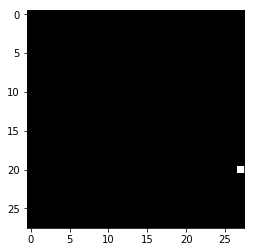

In [23]:
plt.figure()
print(output.shape)
plt.imshow(output[1,1,:,:,:])

In [59]:
# Training the model
conv2dlstm.compile(loss='binary_crossentropy', optimizer='adam')

# # Test data with spatial displacement (1 time step)
# data = np.reshape(np.concatenate([output[1:5000,0,:,:,0],output[1:5000,1,:,:,0],output[1:5000,2,:,:,0]],axis=0), [14997,1,28,28,1])
# data_next = np.reshape(np.concatenate([output[1:5000,1,:,:,0],output[1:5000,2,:,:,0],output[1:5000,3,:,:,0]],axis=0), [14997,1,28,28,1])

# Test data with spatial displacement (3 time steps)
data = np.reshape(output[1:6000,0:3,:,:,0], [-1,3,28,28,1])
data_next = np.reshape(output[1:6000,1:4,:,:,0], [-1,3,28,28,1])

print(data.shape)
print(data_next.shape)
conv2dlstm.fit(data, data_next, batch_size=64,
        epochs=10, validation_split=0.20)


(5999, 2, 28, 28)
(5999, 3, 28, 28, 1)
(5999, 3, 28, 28, 1)
Train on 4799 samples, validate on 1200 samples
Epoch 1/10
4799/4799 [==============================] - 18s 4ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 2/10
4799/4799 [==============================] - 15s 3ms/step - loss: 8.5418e-04 - val_loss: 0.0013
Epoch 3/10
4799/4799 [==============================] - 15s 3ms/step - loss: 7.6540e-04 - val_loss: 9.9759e-04
Epoch 4/10
4799/4799 [==============================] - 15s 3ms/step - loss: 7.2987e-04 - val_loss: 9.3257e-04
Epoch 5/10
4799/4799 [==============================] - 15s 3ms/step - loss: 7.0985e-04 - val_loss: 9.0231e-04
Epoch 6/10
4799/4799 [==============================] - 16s 3ms/step - loss: 7.0243e-04 - val_loss: 9.2745e-04
Epoch 7/10
4799/4799 [==============================] - 16s 3ms/step - loss: 6.9121e-04 - val_loss: 8.6346e-04
Epoch 8/10
4799/4799 [==============================] - 15s 3ms/step - loss: 6.7572e-04 - val_loss: 9.2682e-04
Epoch 9/10
4799/